In [1]:
import os
import sys
import pandas as pd
import numpy as np
import glob
import time
import gget
from scipy.sparse import csr_matrix
import scipy
import scanpy as sc
import anndata as an
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from importlib import reload

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer

# local imports
source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import plotting as plt2

# Load gene data

In [2]:
# load the node centralities
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/core_of_core/node_centralities.parquet"
nodes = pd.read_parquet(fpath)
print(f"{nodes.shape}")

core_threshold_quantile = 0.75
threshold = np.quantile(nodes['norm_score'].fillna(0.0), core_threshold_quantile)
nodes['is_core'] = nodes['norm_score'].fillna(0.0) > threshold
print(nodes['is_core'].value_counts())


# map in the umap coords
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/UMAP/population_mESC_100000_UMAP.csv"
umap = pd.read_csv(fpath)
print(f"(raw) {umap.shape=}")
umap = umap[umap['n_genes'] > 0]
umap['genes'] = umap['genes'].apply(lambda x: x.split(";"))

umap = umap.explode('genes')
print(f"(exploded) {umap.shape=}")
umap = umap[umap['genes'].isin(nodes['gene_name'])]
umap = umap.rename(columns={'genes' : 'gene_name'})
print(f"(filtered) {umap.shape=}")

nodes = pd.merge(nodes, umap, how='left')
nodes = nodes.drop_duplicates(subset='gene_name')
print(f"(final) {nodes.shape=}")
nodes.head()

(24415, 5)
is_core
False    18311
True      6104
Name: count, dtype: int64
(raw) umap.shape=(25681, 7)
(exploded) umap.shape=(60106, 7)
(filtered) umap.shape=(36597, 7)
(final) nodes.shape=(24415, 12)


,gene_name,expression,is_tf,score,norm_score,is_core,bin_name,bin,chrom,n_genes,UMAP 1,UMAP 2
0,Zfp111,5.62,True,0.000175,1.000000,True,chr7:239,10190,7,8,9.531208,-6.571537
2,Gm7803,0.30,False,0.000166,0.952722,True,chrX:494,25127,X,3,5.418215,2.806738
3,Sfxn5,1.18,False,0.000165,0.942303,True,chr6:853,9308,6,2,6.656131,-5.349132
6,Gm35769,0.00,False,0.000164,0.941602,True,chr15:248,20383,15,2,12.558568,6.418924
8,Gm26650,0.00,False,0.000163,0.934134,True,chr14:176,19059,14,5,6.460474,6.306936


# Load Trainning Data

In [3]:
dpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/hypergraph-mt/"

file_list = glob.glob(f"{dpath}train*")
file_list[:3]

['/scratch/indikar_root/indikar1/shared_data/higher_order/hypergraph-mt/train_238.parquet',
 '/scratch/indikar_root/indikar1/shared_data/higher_order/hypergraph-mt/train_56.parquet',
 '/scratch/indikar_root/indikar1/shared_data/higher_order/hypergraph-mt/train_474.parquet']

In [4]:
dpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/hypergraph-mt/"
file_list = glob.glob(f"{dpath}train*")

df = []

for fpath in file_list:
    basename = os.path.basename(fpath).replace(".parquet", "")
    k = int(basename.split("_")[1])
    tmp = pd.read_parquet(fpath)
    scaler = MinMaxScaler()
    tmp['norm'] = scaler.fit_transform(tmp['loglik'].values.reshape(-1, 1)) 
    tmp['k'] = k
    tmp['loglik'] = tmp['loglik'].astype(float)
    df.append(tmp)
    # break

df = pd.concat(df)
df['error'] = df['loglik'] > 0
print(f"number of failed iterations {df['error'].sum()}")
df = df[~df['error']].reset_index(drop=True)
print(f"{df.shape=}")
df.head()

number of failed iterations 496
df.shape=(29718, 9)


,realization,seed,iter,loglik,runtime,reached_convergence,norm,k,error
0,0,10,1,-951075.067375,72.145093,False,0.000000,238,False
1,0,10,2,-939248.971315,70.797906,False,0.039966,238,False
2,0,10,3,-937423.103309,36.510977,False,0.046137,238,False
3,0,10,4,-936223.478580,35.272664,False,0.050191,238,False
4,0,10,5,-935681.773346,31.418142,False,0.052021,238,False


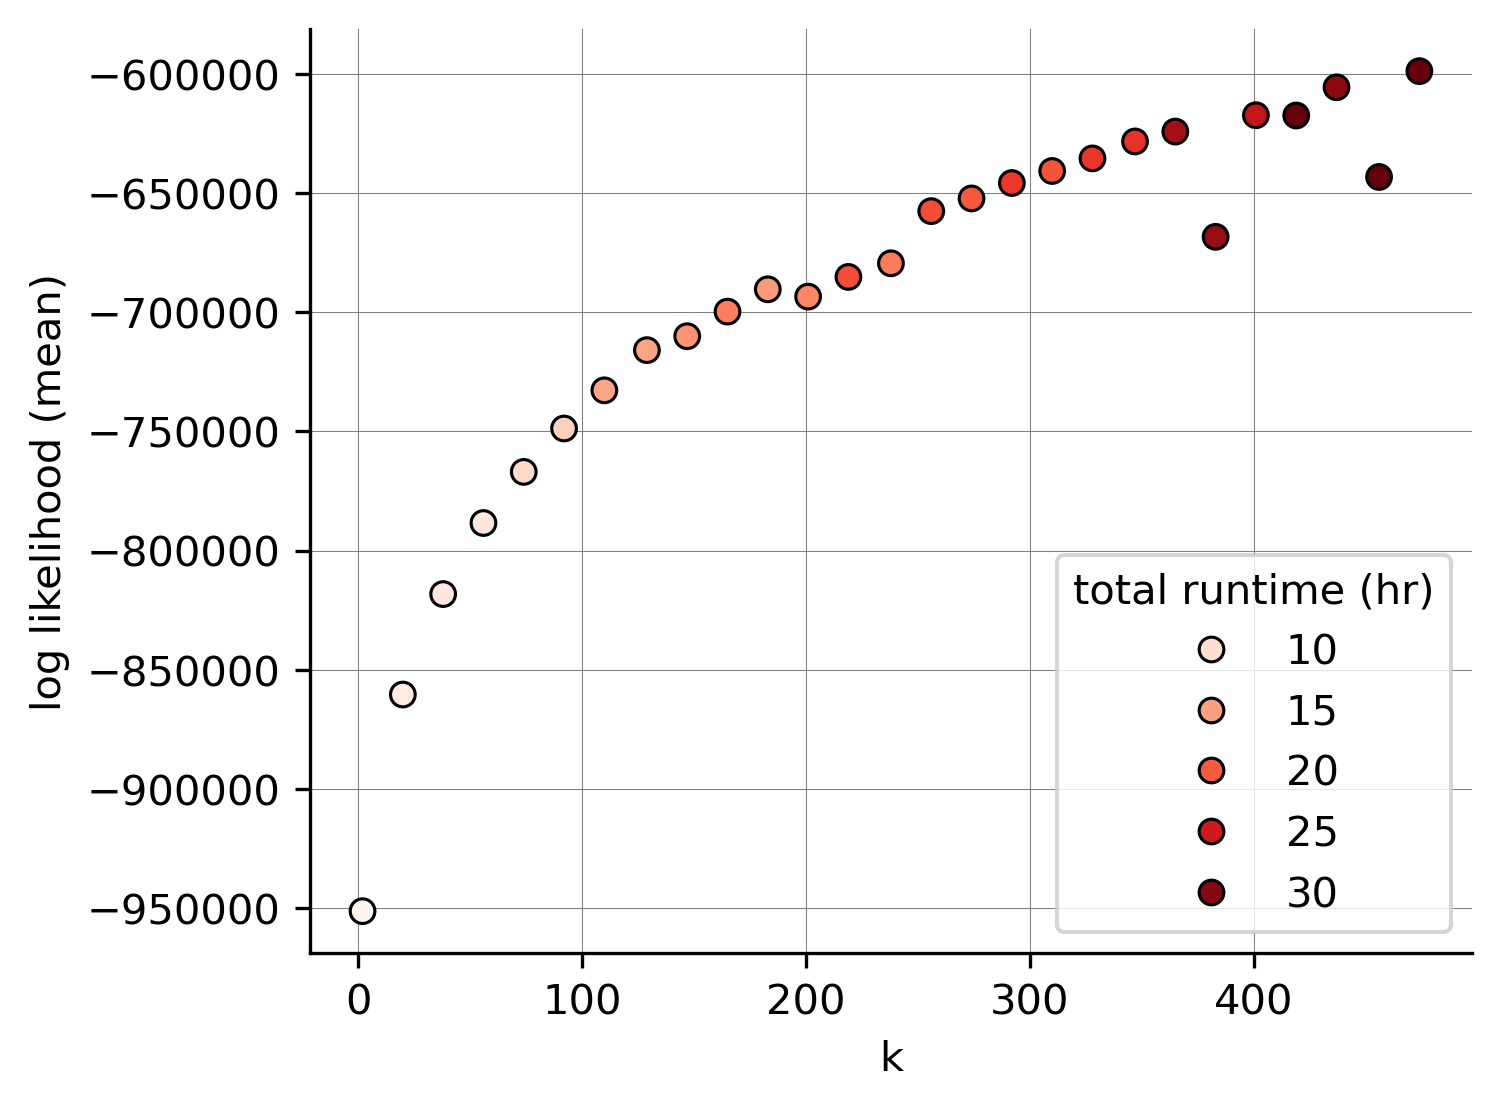

In [5]:
k_threshold = 474

# establish highest log-liklihood
gx = df.groupby('k').agg(
    mean_loglik=('loglik', 'mean'),
    median_loglik=('loglik', 'median'),
    number_iter=('iter', 'count'),
    runtime=('runtime', 'sum'),
    convergence=('reached_convergence', 'max'),
).reset_index()

gx = gx[gx['k'] <= k_threshold]
gx['runtime'] = ((gx['runtime'] / 60) / 60)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 4

sns.scatterplot(
    data=gx, 
    x='k',
    y='mean_loglik',
    hue='runtime',
    ec='k',
    lw=0.75,
    s=35,
    zorder=10,
    palette='Reds',
)

plt.grid(
    color='grey', 
    linestyle='-', 
    linewidth=0.25,
    zorder=0,
)

sns.move_legend(
    plt.gca(), 
    title='total runtime (hr)',
    loc='best',
)
sns.despine()

# plt.gca().tick_params(axis='x', rotation=90)
plt.xlabel("k")
plt.ylabel("log likelihood (mean)")
plt.show()

In [6]:
n = 10
largest_unique_values = df['k'].unique()  # Get unique values
largest_unique_values.sort()  # Sort in ascending order
largest_unique_values = largest_unique_values[-n:]
largest_unique_values

array([347, 365, 383, 401, 419, 437, 456, 474, 528, 583])

In [7]:
np.diff(largest_unique_values)

array([18, 18, 18, 18, 18, 19, 18, 54, 55])

# Memebership

In [8]:
df['k'].max()

583

In [9]:
def normalize_nonzero_membership(u):
    """
        Given a matrix, it returns the same matrix normalized by row.

        INPUT
        -------
        u: ndarray
           Numpy matrix.

        OUTPUT
        -------
        The matrix normalized by row.
    """

    den1 = u.sum(axis=1, keepdims=True)
    nzz = den1 == 0.0
    den1[nzz] = 1.0

    return u / den1

In [10]:
k = 474
print(f"{k=}")

fpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/hypergraph-mt/u_{k}.pkl"
u = pd.read_pickle(fpath)
normed_u = normalize_nonzero_membership(u.to_numpy())
normed_u = pd.DataFrame.sparse.from_spmatrix(
    csr_matrix(normed_u),
    index=u.index, columns=u.columns,
)
print(f"{u.shape=}")
u.head()

k=474
u.shape=(17186, 474)


,group_1,group_2,group_3,group_4,group_5,group_6,group_7,group_8,group_9,group_10,...,group_465,group_466,group_467,group_468,group_469,group_470,group_471,group_472,group_473,group_474
Smarca2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Sh2d5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Dyrk1a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.078138,0.0,0.0,0.0,0.0,0.0,0.0
Igf2bp3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Tmem267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
genes = u.agg(['sum', 'mean', 'max', 'nonzero'], axis=1)
genes['n_groups'] = genes['nonzero'].apply(lambda x: len(x[0]))
genes = pd.merge(
    genes, nodes.set_index('gene_name'), how='left',
    left_index=True,
    right_index=True,
).reset_index(names='gene_name')
genes['log_expression'] = np.log1p(genes['expression'])

genes.head()

,gene_name,sum,mean,max,nonzero,n_groups,expression,is_tf,score,norm_score,is_core,bin_name,bin,chrom,n_genes,UMAP 1,UMAP 2,log_expression
0,Smarca2,0.093337,0.000197,0.093337,"([44],)",1,4.55,False,3.837642e-09,0.000022,False,chr19:265,24283,19,3,4.904234,-2.694967,1.713798
1,Sh2d5,0.853784,0.001801,0.16364,"([130, 162, 266, 286, 385, 444, 457],)",7,1.89,False,5.664674e-07,0.003245,False,chr4:1379,6747,4,6,2.083629,3.465141,1.061257
2,Dyrk1a,0.23436,0.000494,0.156222,"([168, 467],)",2,26.10,False,7.093769e-06,0.040631,False,chr16:943,22119,16,5,2.747340,14.155752,3.299534
3,Igf2bp3,0.896754,0.001892,0.231444,"([59, 142, 216, 327, 365, 424],)",6,53.92,False,3.548019e-05,0.203218,False,chr6:491,8946,6,2,9.599099,-3.664884,4.005878
4,Tmem267,0.08564,0.000181,0.08564,"([171],)",1,0.80,False,3.721996e-05,0.213183,False,chr13:1200,18874,13,3,14.101724,-9.536039,0.587787


,gene_name,sum,mean,max,nonzero,n_groups,expression,is_tf,score,norm_score,is_core,bin_name,bin,chrom,n_genes,UMAP 1,UMAP 2,log_expression
2669,Tmbim6,90.411533,0.190742,1.698196,"([3, 4, 5, 6, 9, 10, 11, 15, 17, 20, 22, 25, 2...",210,160.27,False,1.084515e-04,0.621172,True,chr15:993,21128,15,8,12.662017,3.647366,5.083080
16683,Polm,48.742544,0.102832,3.995158,"([0, 1, 11, 14, 19, 21, 23, 26, 29, 33, 38, 39...",138,10.28,False,1.869328e-09,0.000011,False,chr11:57,15310,11,6,6.920539,8.126325,2.423031
13960,Vmn1r13,37.656386,0.079444,1.670828,"([0, 1, 2, 3, 6, 7, 8, 17, 18, 20, 23, 24, 37,...",135,0.00,False,2.835857e-05,0.162428,False,chr6:571,9026,6,4,8.682390,-3.643528,0.000000
8869,Gucy2d,40.322783,0.085069,2.903034,"([0, 2, 6, 7, 11, 12, 19, 23, 29, 31, 42, 43, ...",124,0.00,False,1.000480e-04,0.573039,True,chr7:981,10932,7,4,9.935813,-8.608336,0.000000
9323,Cdr2l,30.565901,0.064485,2.066518,"([7, 12, 13, 18, 22, 23, 24, 26, 27, 29, 33, 3...",113,15.59,False,1.122277e-05,0.064280,False,chr11:1152,16405,11,7,1.849039,6.402255,2.808800


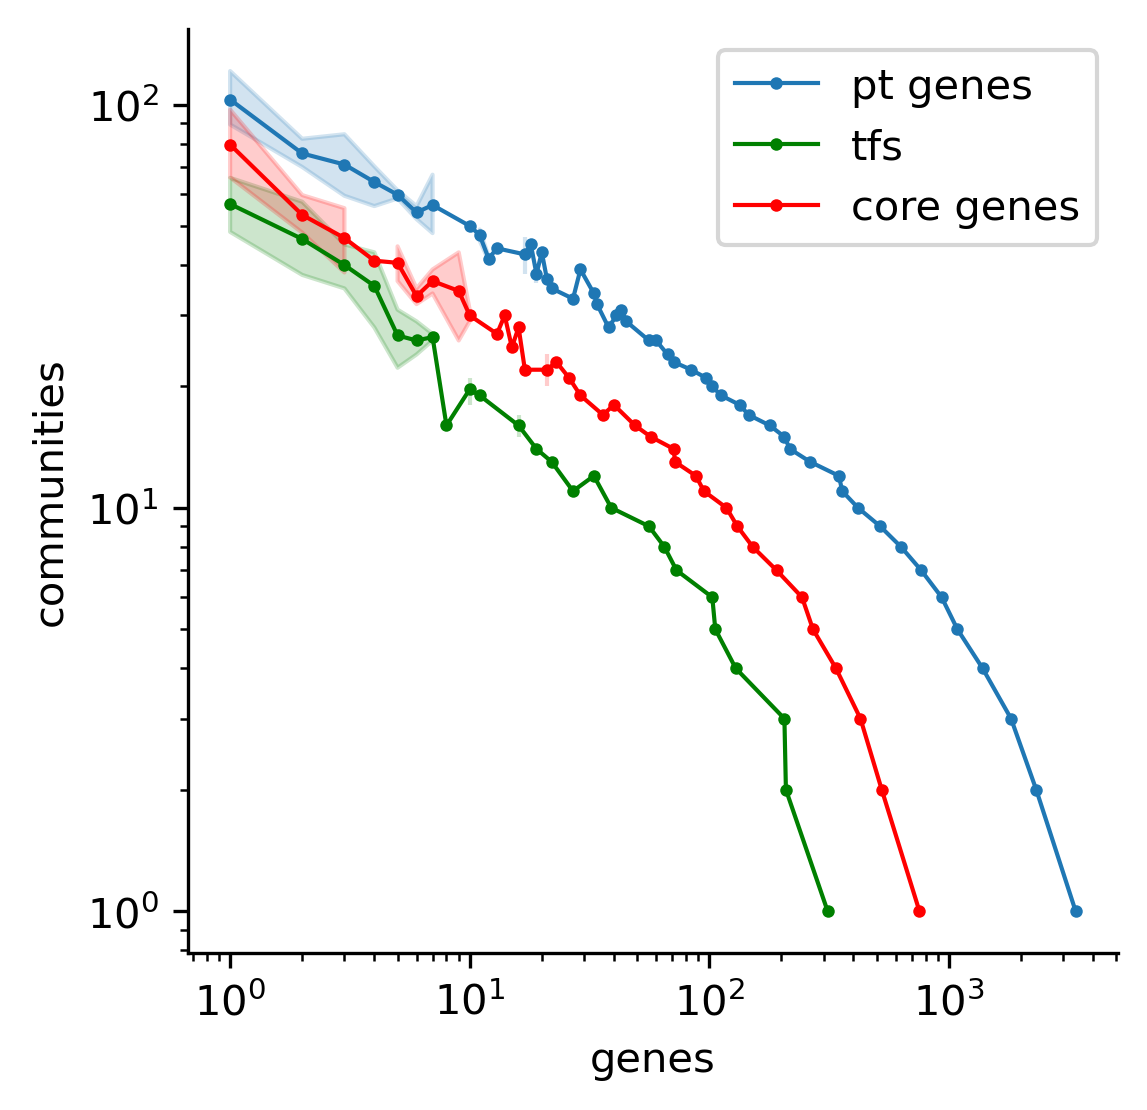

In [12]:
pdf = genes.copy()
pdf = pdf.sort_values(by='n_groups', ascending=False)
pdf = pdf[pdf['n_groups'] > 0]
all_pt = pdf['n_groups'].value_counts().reset_index()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

sns.lineplot(
    data=all_pt,
    x='count',
    y='n_groups',
    lw=1,
    marker=".",
    mec='none',
    label='pt genes',
)


tfs = pdf[pdf['is_tf']]['n_groups'].value_counts().reset_index()

sns.lineplot(
    data=tfs,
    x='count',
    y='n_groups',
    lw=1,
    color='green',
    marker=".",
    mec='none',
    label='tfs',
)


core = pdf[pdf['is_core']]['n_groups'].value_counts().reset_index()

sns.lineplot(
    data=core,
    x='count',
    y='n_groups',
    lw=1,
    color='r',
    marker=".",
    mec='none',
    label='core genes',
)

plt.xlabel('genes')
plt.ylabel('communities')

# Set the scales to logarithmic
plt.xscale('log')
plt.yscale('log')
sns.despine()

pdf.head()


# most promiscusous

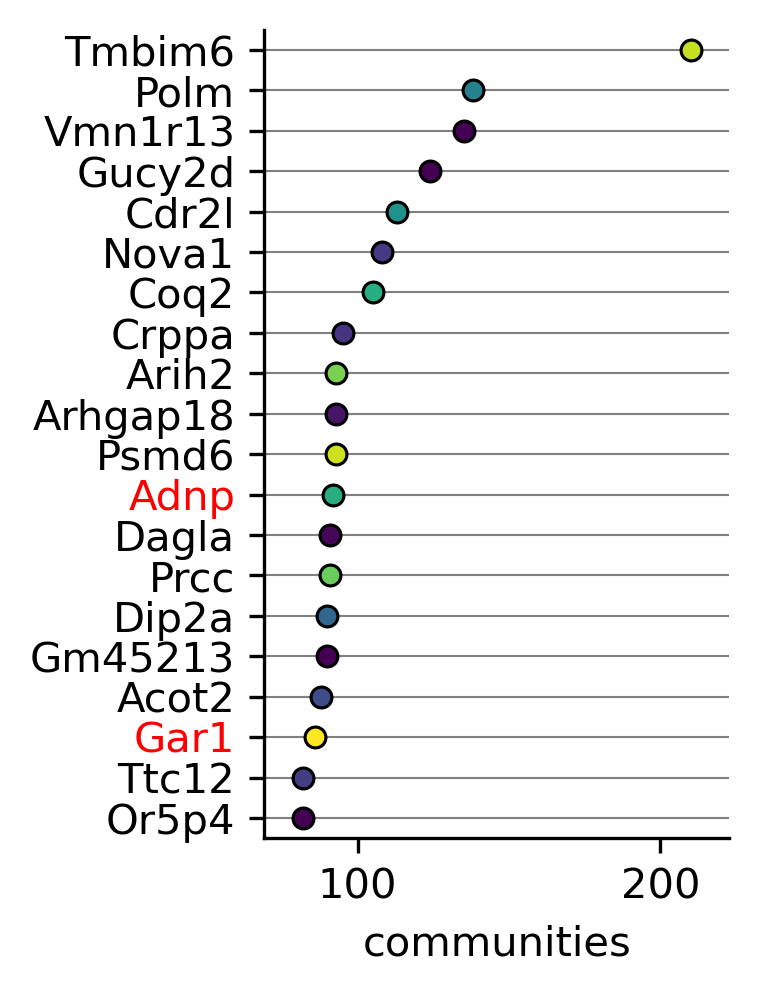

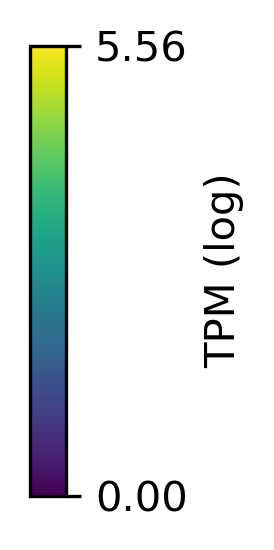

In [13]:
n_plot = 20
cmap = 'viridis' 
pdf = genes.copy()
pdf = pdf.sort_values(by='n_groups', ascending=False)
pdf = pdf[pdf['n_groups'] > 0]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 3.5

sns.stripplot(
    data=pdf.head(n_plot),
    y='gene_name',
    x='n_groups',
    hue='log_expression',
    edgecolor='k',    
    palette=cmap,
    size=5,
    linewidth=0.75,
    legend=False,
)

# Get the y-tick labels
yticklabels = plt.gca().get_yticklabels()

# Iterate through the labels and change color based on 'is_tf'
for i, label in enumerate(yticklabels):
    gene_name = label.get_text()
    if pdf[pdf['gene_name'] == gene_name]['is_tf'].values[0]:
        label.set_color('red')

plt.grid(axis='y', color='grey', linestyle='-', linewidth=0.5)
plt.margins(x=0.1)
plt.ylabel('')
plt.xlabel('communities')
sns.despine()
plt.show()

reload(plt2)
plt2.make_colorbar(
    cmap=cmap,
    width=0.15,
    height=2.5,
    title='TPM (log)',
    orientation='vertical',
    tick_labels=[f"{pdf['log_expression'].head(n_plot).min():.2f}",
                f"{pdf['log_expression'].head(n_plot).max():.2f}"],
)

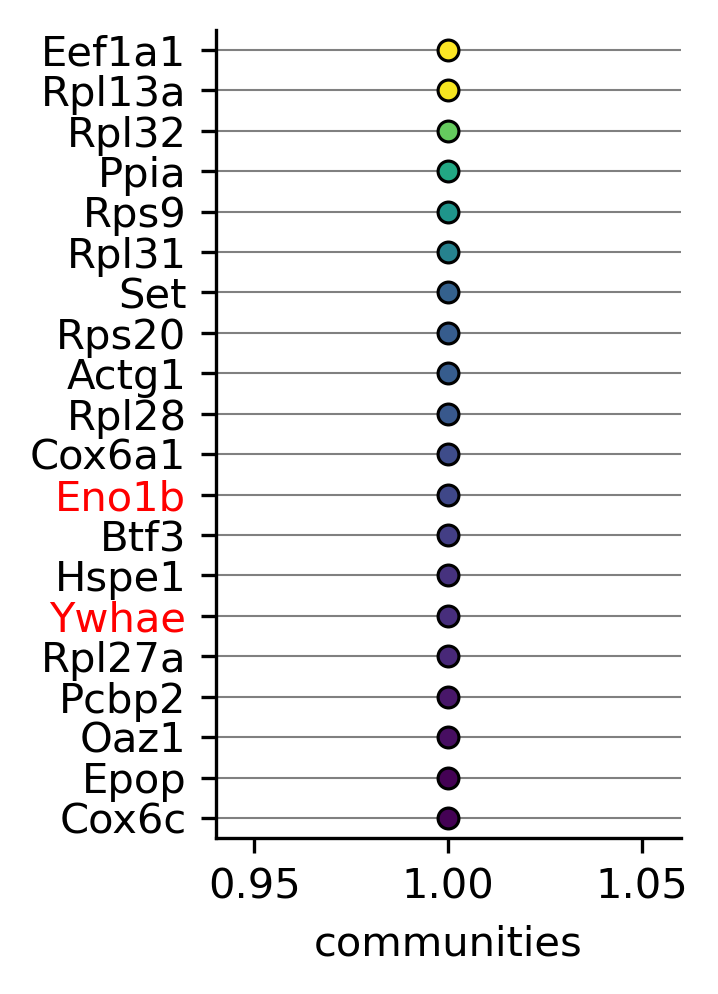

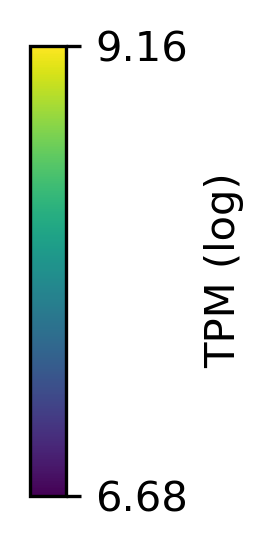

In [14]:
n_plot = 20
cmap = 'viridis' 
pdf = genes.copy()
pdf = pdf.sort_values(by=['n_groups', 'expression'], ascending=[True, False])
pdf = pdf[pdf['n_groups'] > 0]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 3.5

sns.stripplot(
    data=pdf.head(n_plot),
    y='gene_name',
    x='n_groups',
    hue='log_expression',
    edgecolor='k',    
    palette=cmap,
    size=5,
    linewidth=0.75,
    legend=False,
)

# Get the y-tick labels
yticklabels = plt.gca().get_yticklabels()

# Iterate through the labels and change color based on 'is_tf'
for i, label in enumerate(yticklabels):
    gene_name = label.get_text()
    if pdf[pdf['gene_name'] == gene_name]['is_tf'].values[0]:
        label.set_color('red')

plt.grid(axis='y', color='grey', linestyle='-', linewidth=0.5)
plt.margins(x=0.1)
plt.ylabel('')
plt.xlabel('communities')
sns.despine()
plt.show()

reload(plt2)
plt2.make_colorbar(
    cmap=cmap,
    width=0.15,
    height=2.5,
    title='TPM (log)',
    orientation='vertical',
    tick_labels=[f"{pdf['log_expression'].head(n_plot).min():.2f}",
                f"{pdf['log_expression'].head(n_plot).max():.2f}"],
)

In [ ]:
break

# Clustering

In [16]:
""" SET UP AnnData """
var = pd.DataFrame(u.sum(axis=0), columns=['sum'])

obs = u.agg(['sum', 'mean', 'max', 'nonzero'], axis=1)
print(f"(raw) {obs.shape=}")
obs['n_groups'] = obs['nonzero'].apply(lambda x: len(x[0]))

obs = pd.merge(
    obs, nodes.set_index('gene_name'), how='left',
    left_index=True,
    right_index=True,
).reset_index(names='gene_name')
obs['log_expression'] = np.log1p(obs['expression'])
print(f"(filtered) {obs.shape=}")

# create anndata
adata = an.AnnData(
    X=csr_matrix(u.values), 
    obs=obs,
    var=var,
)

adata.layers['u'] = adata.X.copy()
adata.X = adata.X.astype(bool).astype(int)
adata

(raw) obs.shape=(17186, 4)
(filtered) obs.shape=(17186, 18)


AnnData object with n_obs × n_vars = 17186 × 474
    obs: 'gene_name', 'sum', 'mean', 'max', 'nonzero', 'n_groups', 'expression', 'is_tf', 'score', 'norm_score', 'is_core', 'bin_name', 'bin', 'chrom', 'n_genes', 'UMAP 1', 'UMAP 2', 'log_expression'
    var: 'sum'
    layers: 'u'

Computing nearest neighbors...
Running Leiden clustering...


/tmp/ipykernel_884313/603839628.py:13: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


Computing UMAP embedding...


... storing 'bin_name' as categorical
... storing 'chrom' as categorical


Generating UMAP plot...


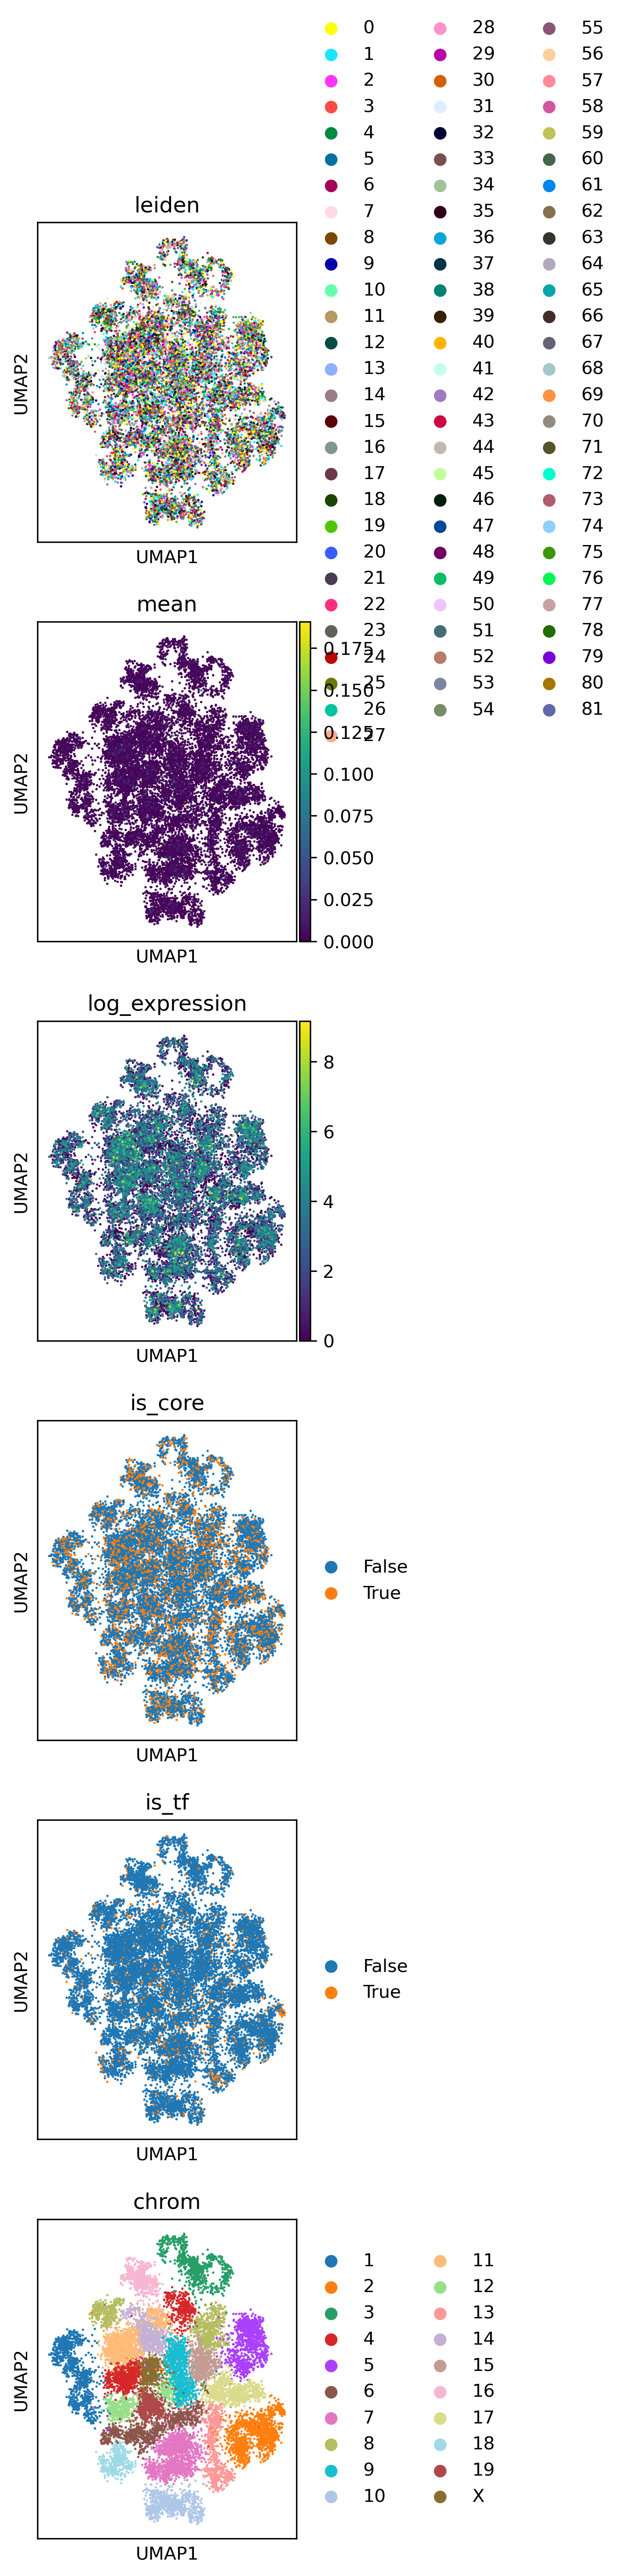

In [17]:
if 'leiden_colors' in adata.uns.keys():
    del adata.uns['leiden_colors']

print("Computing nearest neighbors...")
sc.pp.neighbors(
    adata,
    use_rep='X',
    n_neighbors=5,
    metric='jaccard',
)

print("Running Leiden clustering...")
sc.tl.leiden(
    adata,
    resolution=1.0,
)

print("Computing UMAP embedding...")
sc.tl.umap(
    adata,
    alpha=0.01,
    min_dist=0.9,
    maxiter=10,
    init_pos=adata.obs[['UMAP 1', 'UMAP 2']].to_numpy(),
)

print("Generating UMAP plot...")
sc.pl.umap(
    adata,
    color=["leiden", 'mean', 'log_expression', 'is_core', 'is_tf', 'chrom'],
    ncols=1,
)

In [ ]:
break

# PLOT

In [ ]:
# fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/transcription_clusters/core_incidence_1000000_protien_coding_only.pkl"
# H = pd.read_pickle(fpath)
# print(f"{H.shape=} ({type(H)})")

# """ CLIQUE EXPAND THE MATRIX"""
# sparse_matrix = csr_matrix(H.to_numpy())
# A = sparse_matrix @ sparse_matrix.T
# A = pd.DataFrame.sparse.from_spmatrix(
#     A,
#     index=H.index,
#     columns=H.index,
# )

# print(f"{A.shape=}")

# """ESTABLISH NEW POSITIONS BASED ON THE CLIQUE EXPANSION """
# rows = zip(genes['gene_name'], genes['UMAP 1'].values, genes['UMAP 2'].values)
# init_positions = {gene_name: (umap1, umap2) for gene_name, umap1, umap2 in rows}

# G = nx.from_pandas_adjacency(A)
# pos = nx.spring_layout(
#     G,
#     pos=init_positions,
#     k=0.2,
#     seed=32,
# )

# print(G)

In [ ]:
# rows = zip(genes['gene_name'], genes['UMAP 1'].values, genes['UMAP 2'].values)
# init_positions = {gene_name: (umap1, umap2) for gene_name, umap1, umap2 in rows}

# G = nx.from_pandas_adjacency(A)
# pos = nx.spring_layout(
#     G,
#     pos=init_positions,
#     k=0.2,
#     seed=32,
# )

# print(G)

In [ ]:
genes.columns

In [ ]:
pdf = genes.copy()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4
sns.scatterplot(
    data=pdf.sort_values(by='sum'),
    x='UMAP 1',
    y='UMAP 2',
    hue='sum',
    ec='none',
    palette='hot'
)

In [ ]:
break

# Clustering

In [ ]:
# mixed membership
var = pd.DataFrame(u.sum(axis=0), columns=['sum'])

obs = u.agg(['sum', 'mean', 'max', 'nonzero'], axis=1)
obs['n_groups'] = obs['nonzero'].apply(lambda x: len(x[0]))
obs = pd.merge(
    obs, nodes.set_index('gene_name'), how='left',
    left_index=True,
    right_index=True,
).reset_index(names='gene_name')
obs['log_expression'] = np.log1p(obs['expression'])

# create anndata
adata = an.AnnData(
    X=csr_matrix(u.values), 
    obs=obs,
    var=var,
)
adata

In [ ]:
if 'leiden_colors' in adata.uns.keys():
    del adata.uns['leiden_colors']

sc.pp.normalize_total(adata, target_sum=1)

sc.pp.pca(
    adata,
    n_comps=10,
)

sc.pp.neighbors(
    adata,
    n_neighbors=105,
)

sc.tl.leiden(
    adata,
    resolution=0.25,
)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5
sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata)

sc.tl.umap(
    adata,
    init_pos='paga',
)

sc.pl.umap(
    adata,
    color=["leiden", 'sum', 'log_expression'],
)

In [ ]:
break

In [ ]:
max_count = 100
alpha = 0.05
# database = 'ontology'
database = 'ontology'

counts = pd.DataFrame(adata.obs['leiden'].value_counts().reset_index())

for idx, row in counts.iterrows():
    if int(row['count']) > int(max_count):
        continue

    gene_list = adata[adata.obs['leiden'] == row['leiden'], :].obs_names
    edf = gget.enrichr(list(gene_list), database=database)
    edf['is_sig'] = edf['adj_p_val'] <= alpha
    edf['genes'] = edf['overlapping_genes'].apply(lambda x: ", ".join(x))
    if not edf.empty:
        print(f"Cluster {row['leiden']} ({row['count']} genes):")
        print(edf[['path_name', 'is_sig', 'genes']].head().to_markdown(
            index=False, numalign="left", stralign="left",
        ))
        print()
        time.sleep(5)


# Predictions

In [ ]:
# k = df['k'].max()
# print(f"{k=}")

# fpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/hypergraph-mt/pred_{k}.parquet"
# pred = pd.read_parquet(fpath)
# print(f"(raw) {pred.shape=}")
# pred = pred.drop_duplicates()
# print(f"(filtered) {pred.shape=}")
# pred['nodes'] = pred['hyperedge'].apply(lambda x: x.split("-"))
# pred = pred.reset_index(drop=True)

# pred.head(15)

In [ ]:
break

In [ ]:
# mixed membership
mixed = u.sum(axis=1).reset_index()
mixed.columns = ['gene_name', 'sum']
mixed = mixed.sort_values(by='sum', ascending=False)

mixed = pd.merge(
    mixed, nodes, how='left'
)

mixed.head()

In [ ]:
n_genes = 500
database = 'ontology'
edf = gget.enrichr(mixed['gene_name'].head(n_genes).to_list(), database=database)

edf[['path_name', 'overlapping_genes', 'adj_p_val']].head()

In [ ]:
sns.scatterplot(
    data=mixed,
    x='sum',
    y='norm_score',
    s=4,
    ec='none',
    hue='is_tf',
)

# plt.yscale('log')

In [ ]:
sns.boxplot(
    data=mixed,
    x='is_tf',
    y='communities',
    showfliers=False,
)

In [ ]:
sns.scatterplot(
    data=mixed,
    x='norm_score',
    y='communities',
    hue='is_tf',
    s=1,
    ec='none',
)

In [ ]:
break

In [ ]:
break

In [ ]:
break

In [ ]:
df.head(35)

In [ ]:
break

In [ ]:
sns.scatterplot(
    data=df, 
    x='p',
    y='k',
    ec='none',
)

In [ ]:
gx = df[df['reached_convergence']].groupby('k')['loglik'].max().reset_index()
gx['loglik_abs'] = gx['loglik'].abs()

sns.scatterplot(
    data=gx, 
    x='k',
    y='loglik_abs'
)

plt.yscale('log')

In [ ]:
gx = df[~df['reached_convergence']].groupby(['k', 'iter'])['loglik'].max().reset_index()

sns.lineplot(
    data=gx, 
    x='iter',
    y='loglik',
    hue='k',
    palette='viridis',
    lw=2,
    marker=".",
)

plt.yscale('log')